In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import seaborn as sns
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import skew, kurtosis, jarque_bera

sns.set_theme()

In [5]:
aapl = yf.download('AAPL',
                    start = '2020-01-01',
                    end = '2025-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
aapl.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716087,72.776613,71.466827,71.721034,135480400
2020-01-03,72.009117,72.771745,71.783962,71.941328,146322800
2020-01-06,72.582924,72.621661,70.876090,71.127881,118387200
2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000
2020-01-08,73.403641,73.706271,71.943751,71.943751,132079200


<Axes: xlabel='Date'>

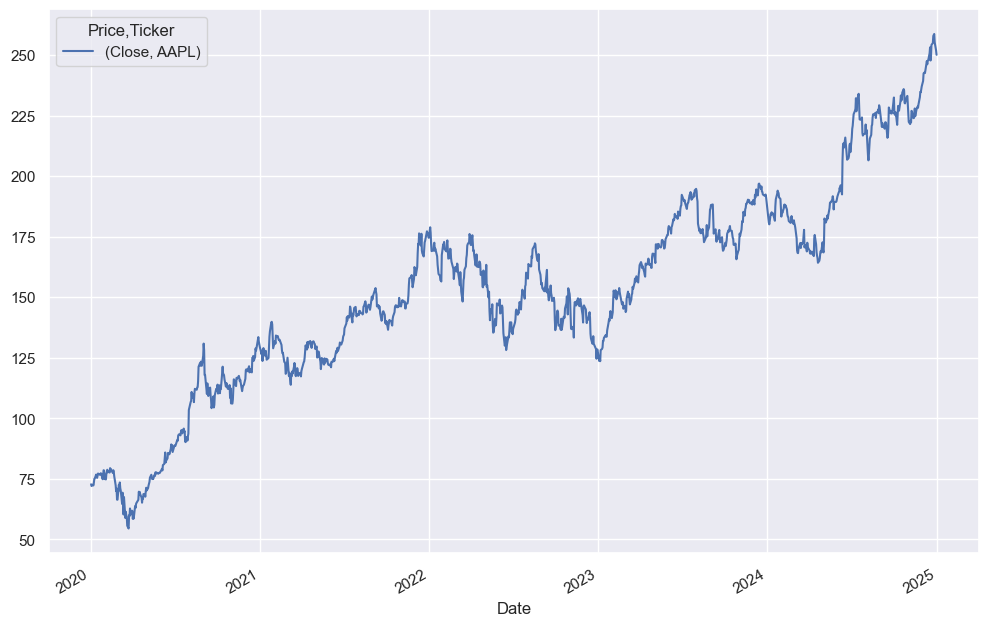

In [4]:
aapl[[('Close', 'AAPL')]].plot(kind = 'line', figsize = (12, 8))

In [5]:
close_values = aapl[('Close', 'AAPL')]
aapl[('log_returns', 'AAPL')] = np.log(close_values / close_values.shift(1))
aapl.dropna(inplace = True)

In [6]:
aapl.head()

Price,Close,High,Low,Open,Volume,log_returns
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-03,72.009117,72.771745,71.783962,71.941328,146322800,-0.009770
2020-01-06,72.582924,72.621661,70.876090,71.127881,118387200,0.007937
2020-01-07,72.241554,72.849231,72.021238,72.592601,108872000,-0.004714
2020-01-08,73.403641,73.706271,71.943751,71.943751,132079200,0.015958
2020-01-09,74.962799,75.156480,74.132383,74.384166,170108400,0.021018


<Axes: xlabel='Date'>

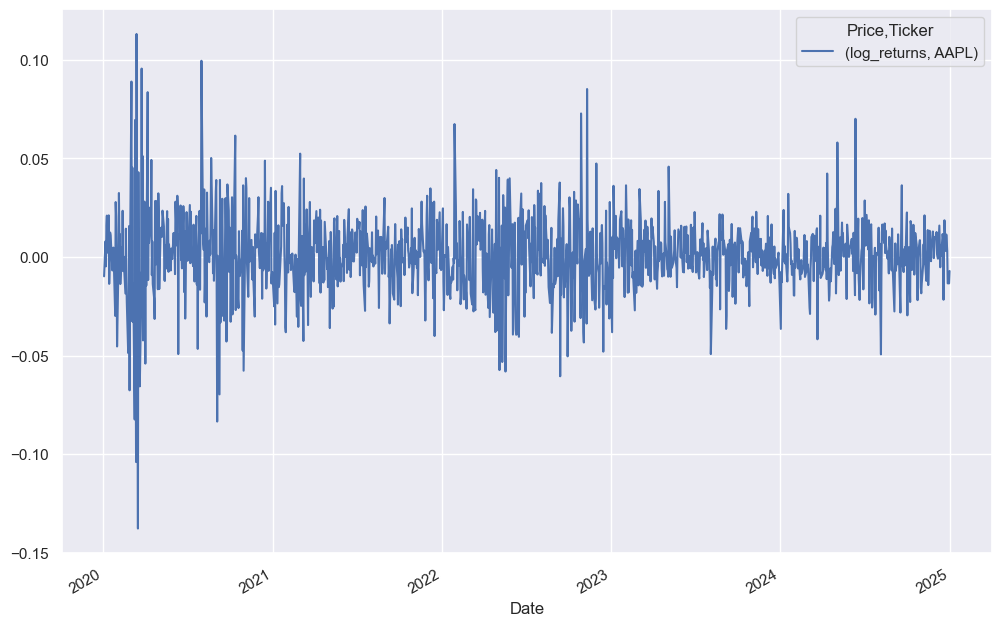

In [7]:
aapl[[('log_returns', 'AAPL')]].plot(kind = 'line', figsize = (12, 8))

<Axes: ylabel='Frequency'>

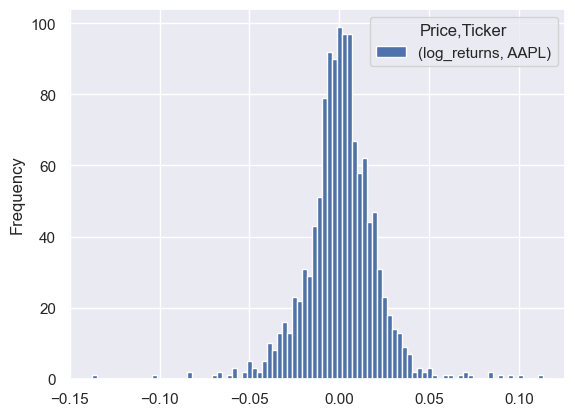

In [8]:
aapl[[('log_returns', 'AAPL')]].plot(kind = 'hist', bins = 90)

In [9]:
jarque_bera(aapl[[('log_returns', 'AAPL')]])

SignificanceResult(statistic=np.float64(1505.7948638444059), pvalue=np.float64(0.0))

Veamos que el p-valor es inferir al nivel de significanci $\alpha = 0,05$

### Movimiento Browniano Geometrico
$$S_t = S_{(t-1)} e^{(\mu \Delta t + \sigma \varepsilon \sqrt{\Delta t})}$$

Donde $\varepsilon$ sigue una distribucion Normal estandar $(\varepsilon \sim N(0,1))$

In [10]:
tickers = ['NFLX', 'TSLA', 'BRK-B']

data = yf.download(tickers, start = '2020-08-17', end='2021-08-16', group_by='ticker', threads=True)

[*********************100%***********************]  3 of 3 completed


<Axes: xlabel='Date'>

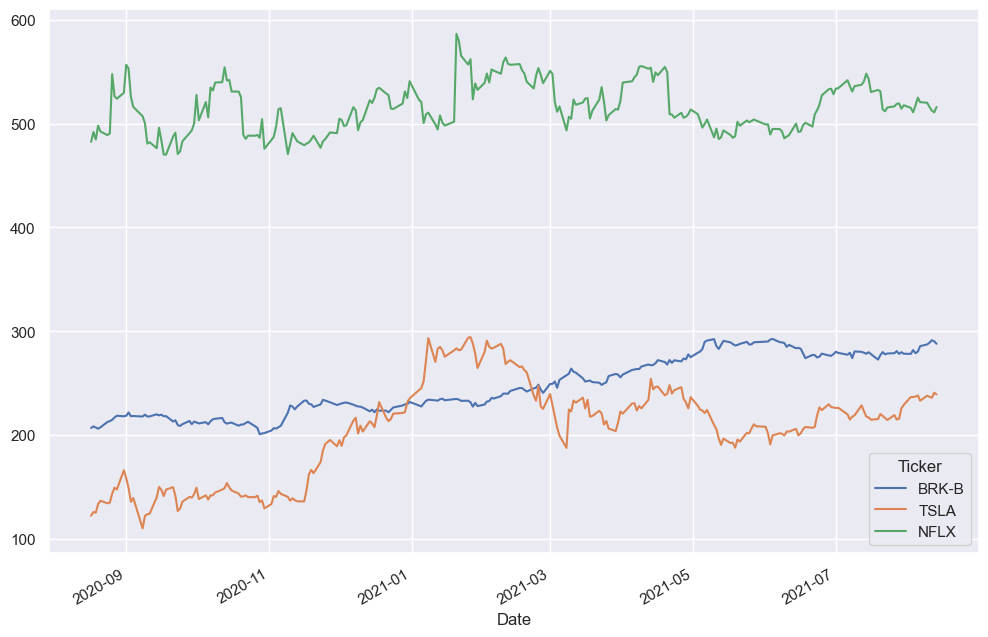

In [11]:
close_prices = data.xs('Close', axis=1, level=1)
close_prices.plot(kind = 'line', figsize = (12, 8))

<Axes: xlabel='Date'>

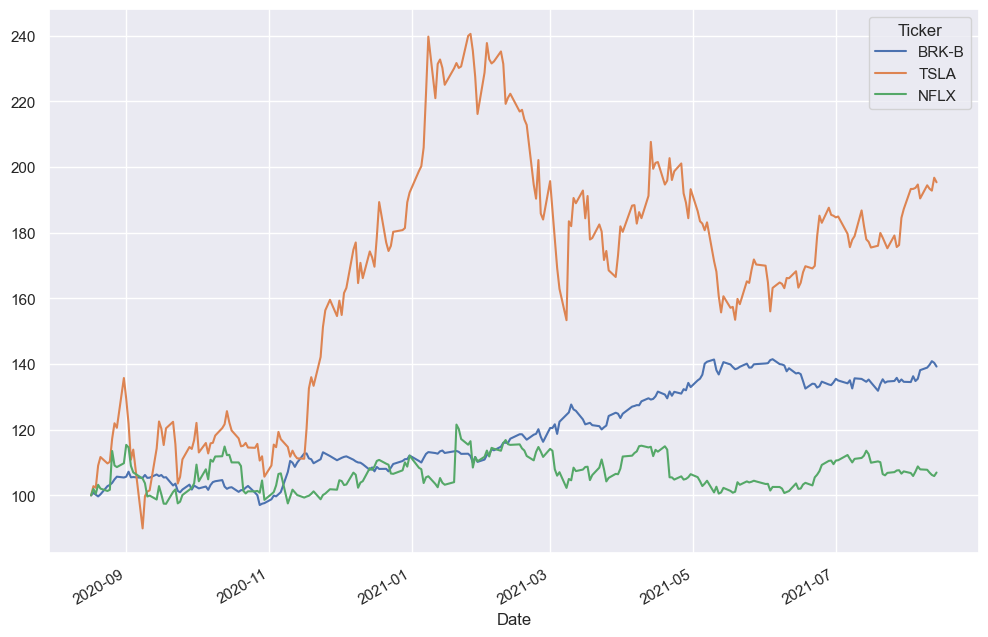

In [12]:
normalize_prices = close_prices.div(close_prices.iloc[0]).mul(100)
normalize_prices.plot(kind = 'line', figsize=(12, 8))

In [13]:
simple_returns = close_prices.pct_change().dropna()

<Axes: xlabel='Date'>

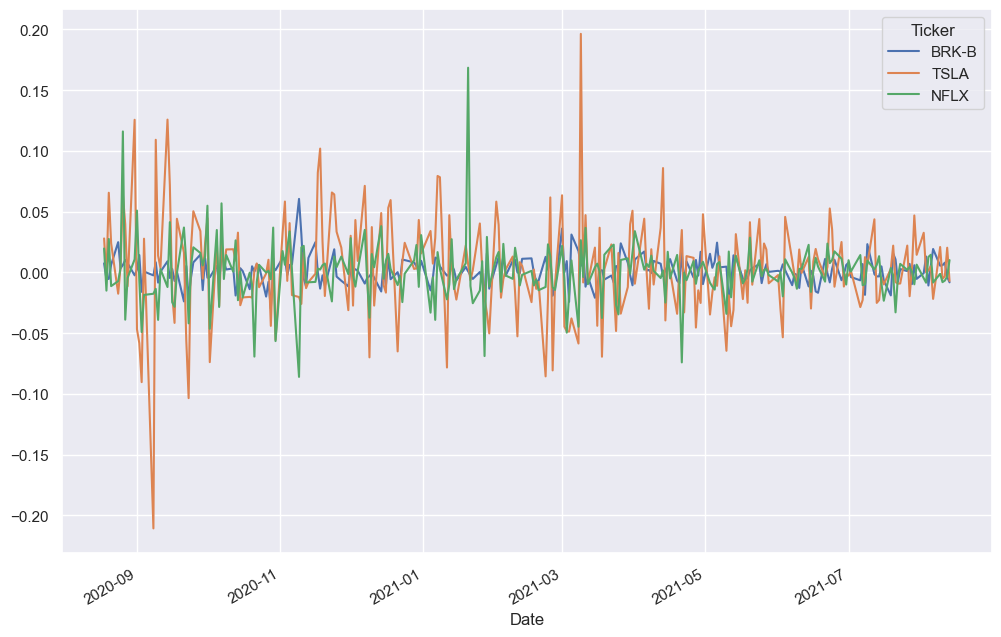

In [14]:
simple_returns.plot(kind='line', figsize=(12,8))

In [15]:
daily_returns = simple_returns.apply('mean')
daily_risk = simple_returns.apply('std')

In [16]:
daily_returns

Ticker
BRK-B    0.001386
TSLA     0.003528
NFLX     0.000559
dtype: float64

In [17]:
yearly_returns = daily_returns.apply(lambda x : (1 + x)**252 -1)
yearly_risk = daily_risk.apply(lambda x : x * np.sqrt(252))

In [18]:
return_risk = pd.concat([yearly_returns, yearly_risk], axis=1)
return_risk.columns = ['yearly_returns', 'yearly_risk']

In [19]:
return_risk

,yearly_returns,yearly_risk
Ticker,,
BRK-B,0.417613,0.176487
TSLA,1.428969,0.653570
NFLX,0.151194,0.386122


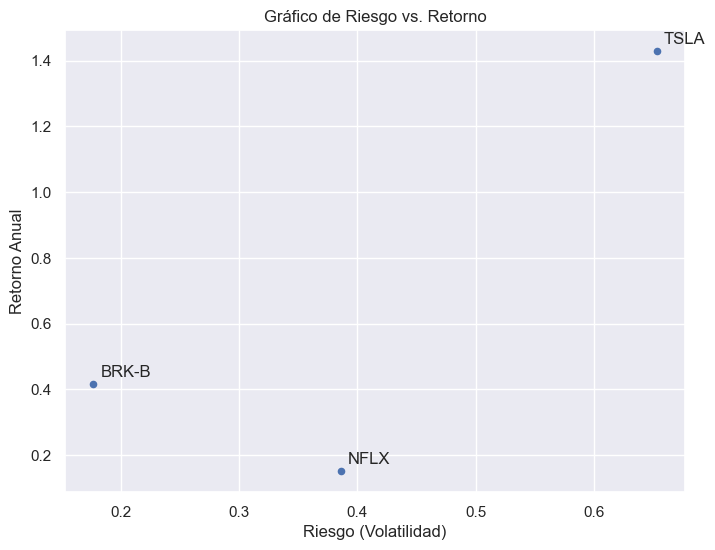

In [20]:
ax = return_risk.plot(
    kind='scatter', 
    x='yearly_risk', 
    y='yearly_returns', 
    figsize=(8,6),
    title='Gráfico de Riesgo vs. Retorno'
)

for ticker, row in return_risk.iterrows():
    ax.annotate(
        ticker,
        (row['yearly_risk'], row['yearly_returns']),
        xytext=(5,5),
        textcoords='offset points'
    )

plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Anual')
plt.show()

los pesos se obtiene al multiplicar la cantidad de acciones por el ultimo precio observado  
Ajuste de los pesos 

In [32]:
last_price = close_prices.tail(1)
shares = {'BRK-B': 3, 'NFLX':  2, 'TSLA': 2}

In [33]:
final_prices = last_price * shares.values()

In [34]:
last_price

Ticker,BRK-B,TSLA,NFLX
Date,,,
2021-08-13,287.890015,239.056671,515.919983


In [35]:
final_prices

Ticker,BRK-B,TSLA,NFLX
Date,,,
2021-08-13,863.670044,478.113342,1031.839966


In [36]:
weights = final_prices / sum(final_prices.iloc[0])
weights.reset_index(drop=True, inplace = True)

In [37]:
weights

Ticker,BRK-B,TSLA,NFLX
0,0.363861,0.201428,0.434711


In [38]:
return_risk['yearly_returns'] @ weights.values.reshape(-1)

np.float64(0.5055126696170077)

In [28]:
covariance = simple_returns.cov()

In [29]:
covariance

Ticker,BRK-B,TSLA,NFLX
Ticker,,,
BRK-B,0.000124,0.000034,-0.000008
TSLA,0.000034,0.001695,0.000322
NFLX,-0.000008,0.000322,0.000592


In [30]:
weighted_var = weights.values.reshape(-1) @ covariance @ weights.values.reshape(-1)

In [31]:
np.sqrt(weighted_var)

np.float64(0.017845623756660253)

In [11]:
(0.45*0.2 + 0.55*0.1)

0.14500000000000002

In [21]:
np.sqrt((0.45*0.171)**2 + (0.55*0.208)**2 + (2*0.45*0.55*0.171*0.208*0))

np.float64(0.13787190613029182)